In [1]:
# Data handling
import pandas as pd  
import numpy as np  

# Visualization
import matplotlib.pyplot as plt  
import seaborn as sns  
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Text Processing
import nltk  
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords  
from nltk.stem import PorterStemmer  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  

# Machine Learning
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  

# Ignore Warnings
import warnings  
warnings.filterwarnings('ignore')

# Download NLTK dependencies (Run once)
nltk.download('punkt')  
nltk.download('stopwords')  


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd

# Load the dataset with the correct folder path
train_df = pd.read_csv("liar_dataset/train.tsv", sep='\t', header=None)
test_df = pd.read_csv("liar_dataset/test.tsv", sep='\t', header=None)
valid_df = pd.read_csv("liar_dataset/valid.tsv", sep='\t', header=None)

# Display first few rows
print(train_df.head())


           0            1                                                  2   \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                                   3               4                     5   \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

         6           7     8     9    

In [3]:
import pandas as pd

# Define column names
column_names = [
    "id", "label", "statement", "subject", "speaker", "speaker_job",
    "state", "party", "barely_true", "false", "half_true", "mostly_true",
    "pants_on_fire", "context"
]

# Load the dataset with correct column names
train_df = pd.read_csv("liar_dataset/train.tsv", sep='\t', names=column_names)
test_df = pd.read_csv("liar_dataset/test.tsv", sep='\t', names=column_names)
valid_df = pd.read_csv("liar_dataset/valid.tsv", sep='\t', names=column_names)

# Display first few rows
print(train_df.head())


           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker           speaker_job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true  

In [4]:
# Define column names
column_names = [
    "id", "label", "statement", "subject", "speaker", "speaker_job",
    "state", "party", "barely_true", "false", "half_true", "mostly_true",
    "pants_on_fire", "context"
]

# Load dataset
df = pd.read_csv("liar_dataset/train.tsv", sep="\t", names=column_names, na_values=[""])

# Drop unnecessary columns
df.drop(columns=["id", "context"], inplace=True)

# Basic Info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          10240 non-null  object 
 1   statement      10240 non-null  object 
 2   subject        10238 non-null  object 
 3   speaker        10238 non-null  object 
 4   speaker_job    7342 non-null   object 
 5   state          8030 non-null   object 
 6   party          10238 non-null  object 
 7   barely_true    10238 non-null  float64
 8   false          10238 non-null  float64
 9   half_true      10238 non-null  float64
 10  mostly_true    10238 non-null  float64
 11  pants_on_fire  10238 non-null  float64
dtypes: float64(5), object(7)
memory usage: 960.1+ KB
None
         label                                          statement  \
0        false  Says the Annies List political group supports ...   
1    half-true  When did the decline of coal start? It started...   
2  mostly

In [5]:
# Check missing values
print("Missing values in each column:\n", df.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary statistics:\n", df.describe())

# Check unique values in categorical columns
print("\nUnique values in categorical columns:")
for col in ["label", "subject", "speaker", "speaker_job", "state", "party"]:
    print(f"{col}: {df[col].nunique()}")


Missing values in each column:
 label               0
statement           0
subject             2
speaker             2
speaker_job      2898
state            2210
party               2
barely_true         2
false               2
half_true           2
mostly_true         2
pants_on_fire       2
dtype: int64

Summary statistics:
         barely_true         false     half_true   mostly_true  pants_on_fire
count  10238.000000  10238.000000  10238.000000  10238.000000   10238.000000
mean      11.533210     13.286482     17.133718     16.434265       6.201407
std       18.973764     24.112936     35.846511     36.151688      16.128927
min        0.000000      0.000000      0.000000      0.000000       0.000000
25%        0.000000      0.000000      0.000000      0.000000       0.000000
50%        2.000000      2.000000      3.000000      3.000000       1.000000
75%       12.000000     12.000000     13.000000     11.000000       5.000000
max       70.000000    114.000000    160.000000    16

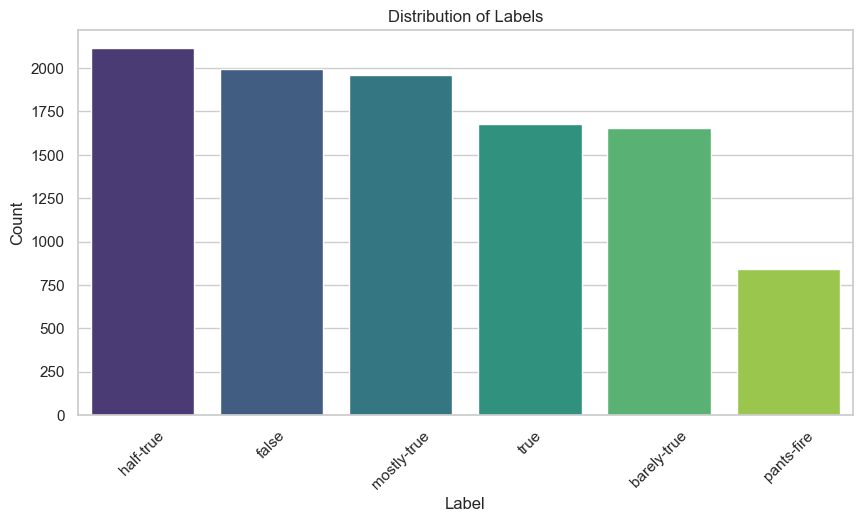

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Label distribution
plt.figure(figsize=(10,5))
sns.countplot(x=df["label"], order=df["label"].value_counts().index, palette="viridis")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          10240 non-null  object 
 1   statement      10240 non-null  object 
 2   subject        10238 non-null  object 
 3   speaker        10238 non-null  object 
 4   speaker_job    7342 non-null   object 
 5   state          8030 non-null   object 
 6   party          10238 non-null  object 
 7   barely_true    10238 non-null  float64
 8   false          10238 non-null  float64
 9   half_true      10238 non-null  float64
 10  mostly_true    10238 non-null  float64
 11  pants_on_fire  10238 non-null  float64
dtypes: float64(5), object(7)
memory usage: 960.1+ KB
None

Missing Values:
label               0
statement           0
subject             2
speaker             2
speaker_job      2898
state            2210
party               2
barely_true         2
false    

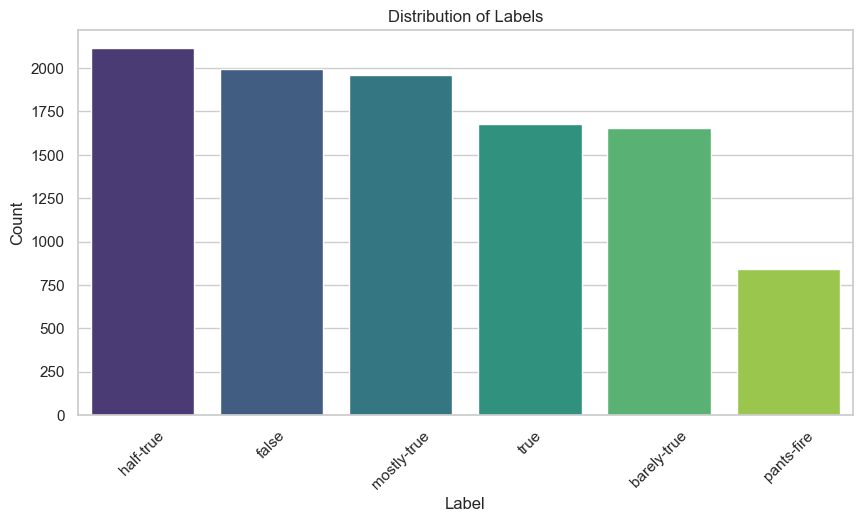

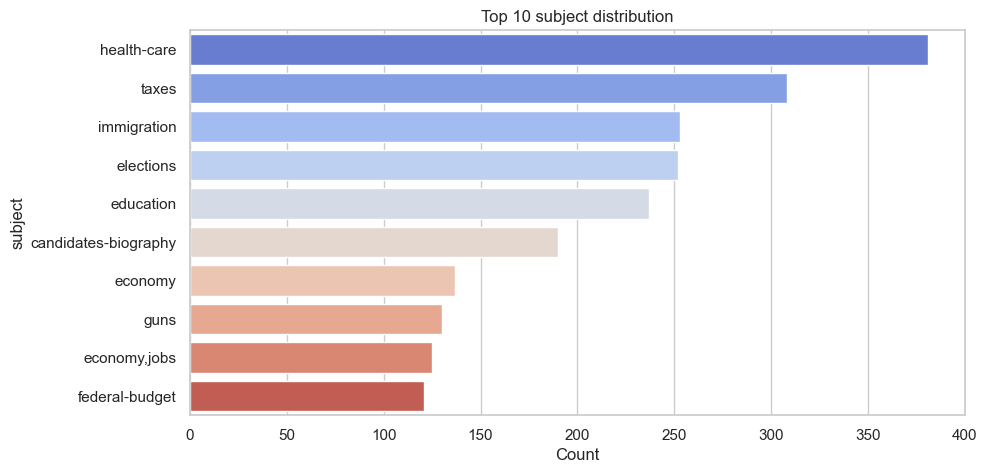

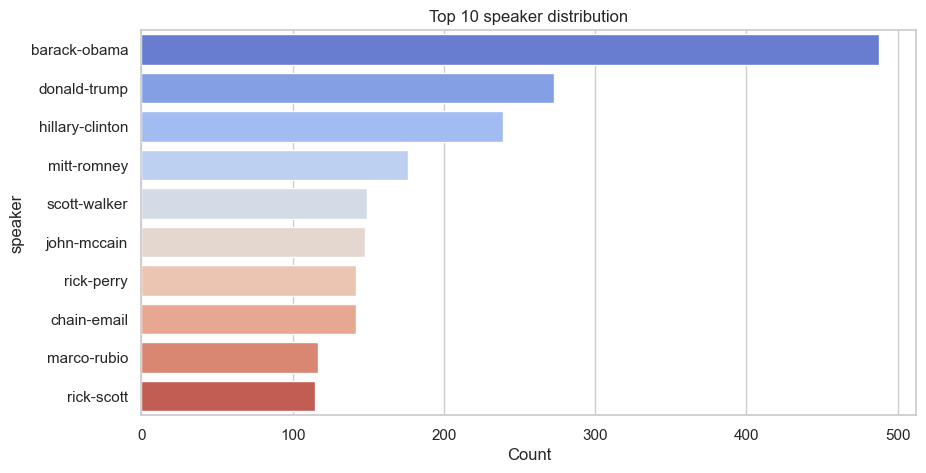

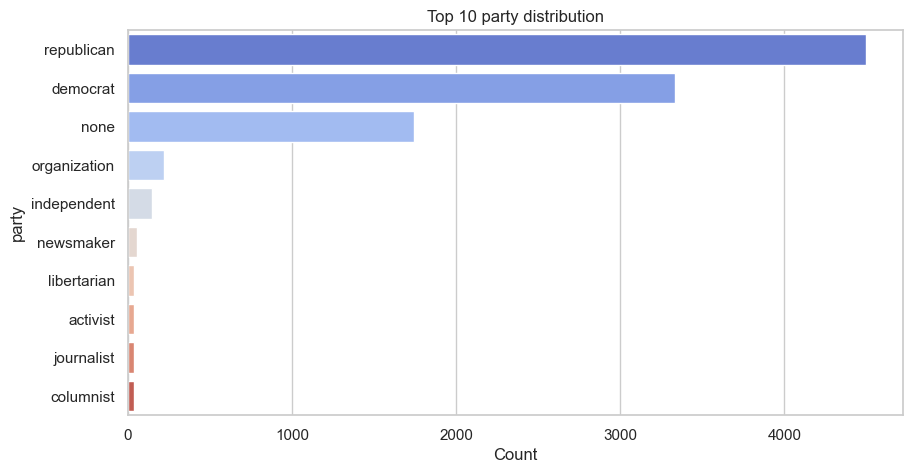

In [7]:
print("Dataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Visualizing label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=df['label'], order=df['label'].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

# Checking categorical feature distributions
categorical_features = ["subject", "speaker", "party"]
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[feature], order=df[feature].value_counts().index[:10], palette="coolwarm")
    plt.xlabel("Count")
    plt.ylabel(feature)
    plt.title(f"Top 10 {feature} distribution")
    plt.show()


In [8]:
# Handling missing values
df.fillna({"subject": "Unknown", "speaker": "Unknown", "speaker_job": "Unknown", "state": "Unknown", "party": "Unknown"}, inplace=True)

# Verify again
print("\nMissing Values after filling:")
print(df.isnull().sum())



Missing Values after filling:
label            0
statement        0
subject          0
speaker          0
speaker_job      0
state            0
party            0
barely_true      2
false            2
half_true        2
mostly_true      2
pants_on_fire    2
dtype: int64


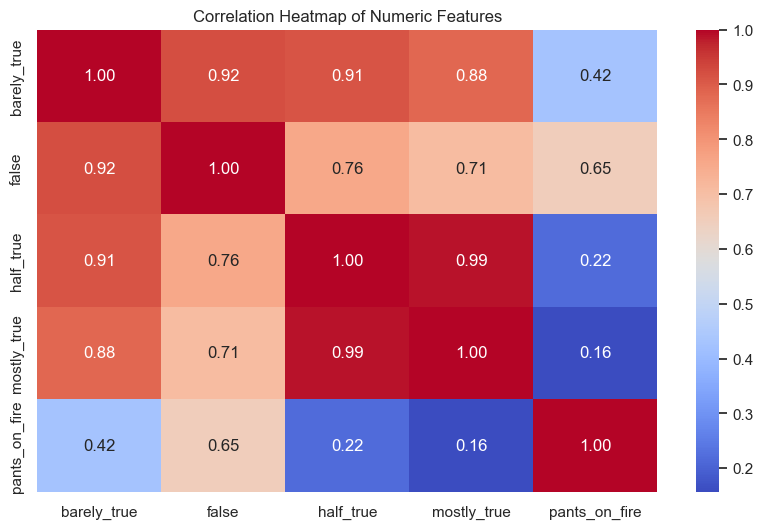

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Selecting only numerical columns for correlation
numeric_cols = df.select_dtypes(include=['number'])

# Plot heatmap
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [10]:
# Filling missing values in numeric columns with 0
df[['barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire']] = df[['barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire']].fillna(0)

# Confirm missing values are handled
print(df.isnull().sum())


label            0
statement        0
subject          0
speaker          0
speaker_job      0
state            0
party            0
barely_true      0
false            0
half_true        0
mostly_true      0
pants_on_fire    0
dtype: int64


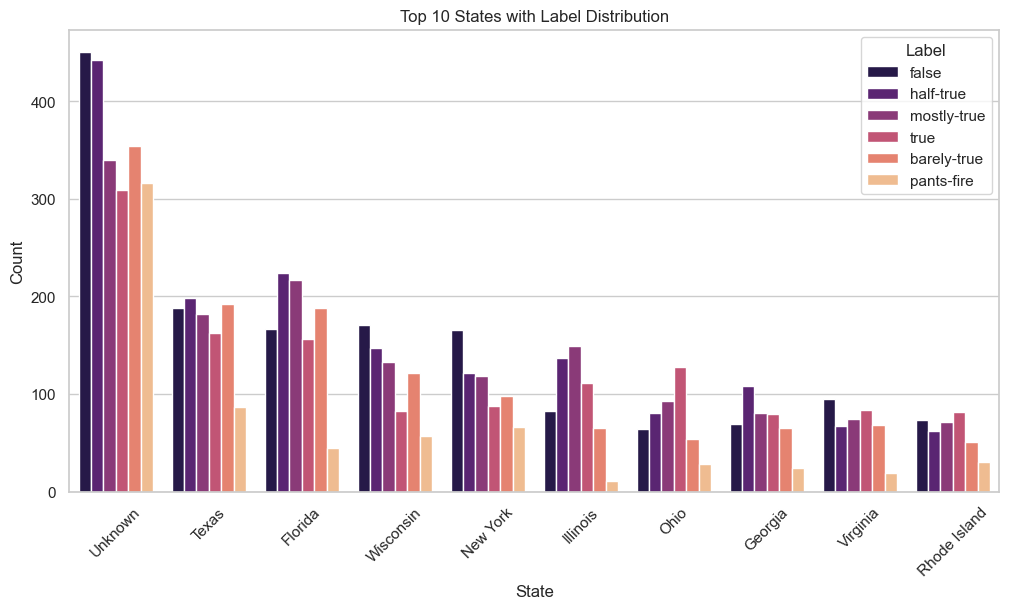

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(x=df['state'], hue=df['label'], palette="magma", order=df['state'].value_counts().index[:10])
plt.title("Top 10 States with Label Distribution")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Label", bbox_to_anchor=(1,1))
plt.show()


In [12]:
!pip install transformers


In [13]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def clean_text(text):
    tokens = tokenizer.tokenize(text)  # Tokenize using BERT
    return " ".join(tokens)  # Join tokens back into a string

# Apply the function to your dataset
df["clean_statement"] = df["statement"].apply(clean_text)


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [14]:
import spacy
import re  

# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # Remove special characters
    doc = nlp(text)  
    words = [token.text for token in doc if not token.is_stop]  # Remove stopwords
    return " ".join(words)

df["clean_statement"] = df["statement"].apply(clean_text)


In [15]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    words = text.split()  
    stemmed_words = [stemmer.stem(word) for word in words]  # Apply stemming
    return " ".join(stemmed_words)

df["stemmed_statement"] = df["clean_statement"].apply(stem_text)


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Generate Unigrams
unigram_vectorizer = CountVectorizer(ngram_range=(1,1))
unigram_features = unigram_vectorizer.fit_transform(df["clean_statement"])

# Generate Bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_features = bigram_vectorizer.fit_transform(df["clean_statement"])

# Generate Trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_features = trigram_vectorizer.fit_transform(df["clean_statement"])


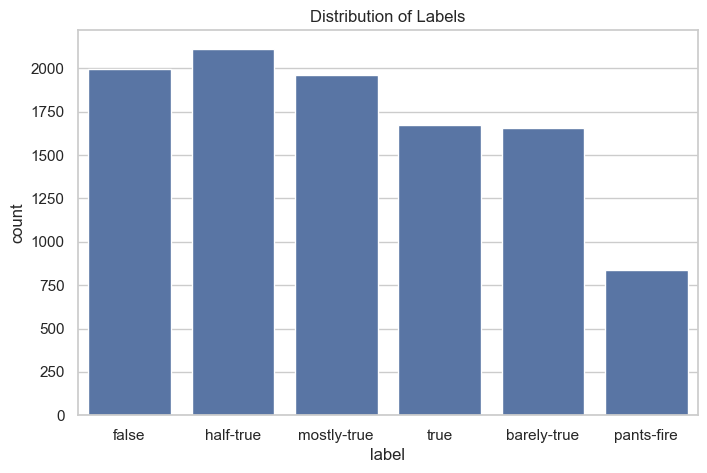

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x=df['label'])
plt.title("Distribution of Labels")
plt.show()


In [18]:
df["word_count"] = df["clean_statement"].apply(lambda x: len(str(x).split()))


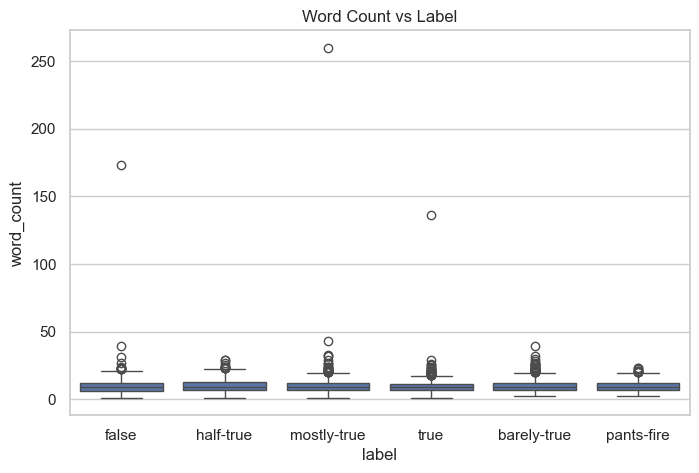

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x=df['label'], y=df['word_count'])
plt.title("Word Count vs Label")
plt.show()


In [20]:
print(df.dtypes)


label                 object
statement             object
subject               object
speaker               object
speaker_job           object
state                 object
party                 object
barely_true          float64
false                float64
half_true            float64
mostly_true          float64
pants_on_fire        float64
clean_statement       object
stemmed_statement     object
word_count             int64
dtype: object


In [21]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Encode categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = encoder.fit_transform(df[col])


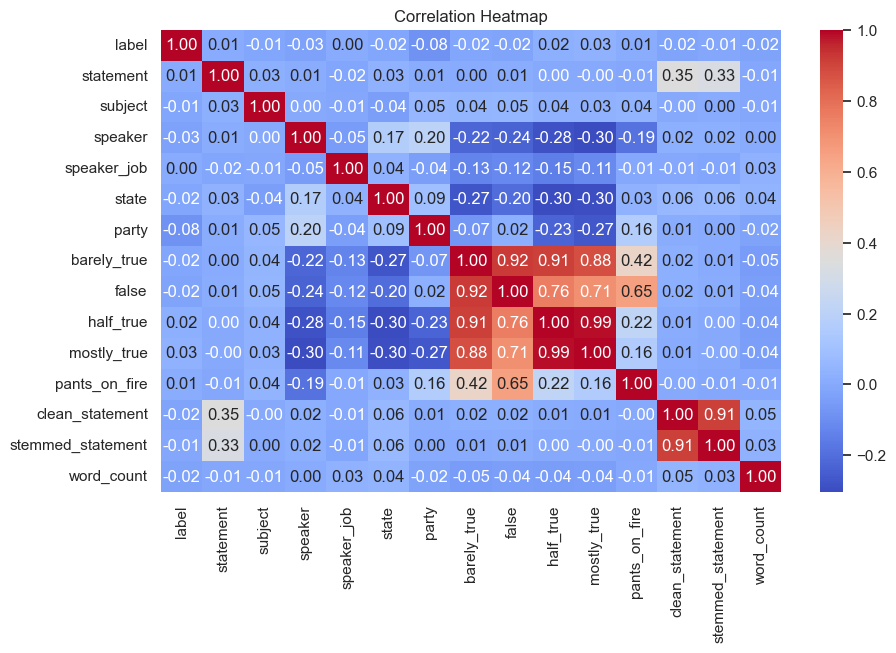

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [24]:
df["clean_statement"] = df["clean_statement"].astype(str)  # Convert to string
df["clean_statement"] = df["clean_statement"].fillna("")   # Replace NaN values with an empty string


In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(df["clean_statement"])


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df["label"], test_size=0.2, random_state=42)
